# Forecasting Training

### Import Modules and Data

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_excel('./CallData_Training_cleaned.xlsx',sheet_name='test_df')

### Create Forecasting DataFrame

In [23]:
fcst_df = df.iloc[:,[1,3,4]]

In [24]:
fcst_df.head(8)

,LocalDay,Interval,TotalDuration
0,2019-04-13,08:00:00,1030
1,2019-04-13,08:30:00,2058
2,2019-04-13,09:00:00,1079
3,2019-04-13,09:30:00,5056
4,2019-04-13,10:00:00,3552
5,2019-04-13,10:30:00,3182
6,2019-04-13,11:00:00,2531
7,2019-04-13,11:30:00,1633


### Explore Data

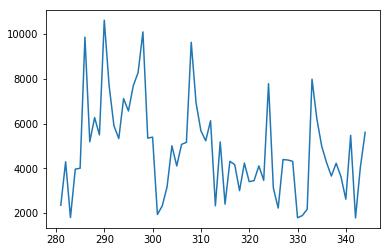

In [25]:
plt.plot(fcst_df.iloc[-64:,2])

### Split Data

In [26]:
train_df = fcst_df.iloc[:-16,2].copy()
test_df = fcst_df.iloc[-16:,2].copy()

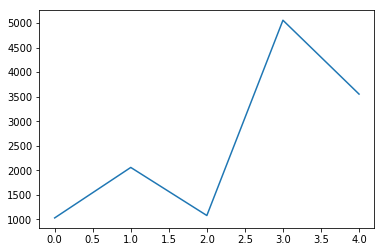

In [27]:
plt.plot(train_df.iloc[:,].head())

### Forecast Error Function
### $MAPE = \frac{1}{n} \sum \frac{|y - \hat{y}|}{y}$

In [28]:
def fcst_error(actual, forecast):
    error_df = abs(actual - forecast) / actual
    return float(error_df.mean())

### Plot Data Function

In [30]:
def fcst_plot(hist,fcst):
    plt.figure(figsize=(16,8))
    plt.plot(hist,'b-',label='History')
    plt.plot(fcst,'r--',label='fcst')
    plt.axvspan(fcst_df.index[-16],fcst_df.index.max(),alpha=0.9,color='lightgrey')
    plt.legend(loc='best')
    plt.grid(True)
    
    mape_df = pd.DataFrame(hist,columns=['TotalDuration'])
    mape = fcst_error(mape_df[-16:],fcst.iloc[-16:])
    print('MAPE:',mape)

# Forecast Types

### Naive Forecast:
### $\hat{y}_{x+1} = y_{x}$

In [29]:
def naive(hist,periods=16):
    fcst_df = hist.copy()
    fcst = int(hist.iloc[-1:,])
    for i in range(len(hist)+periods):
        fcst_df.loc[i] = fcst
    return fcst_df

MAPE: 0.4848353451638203


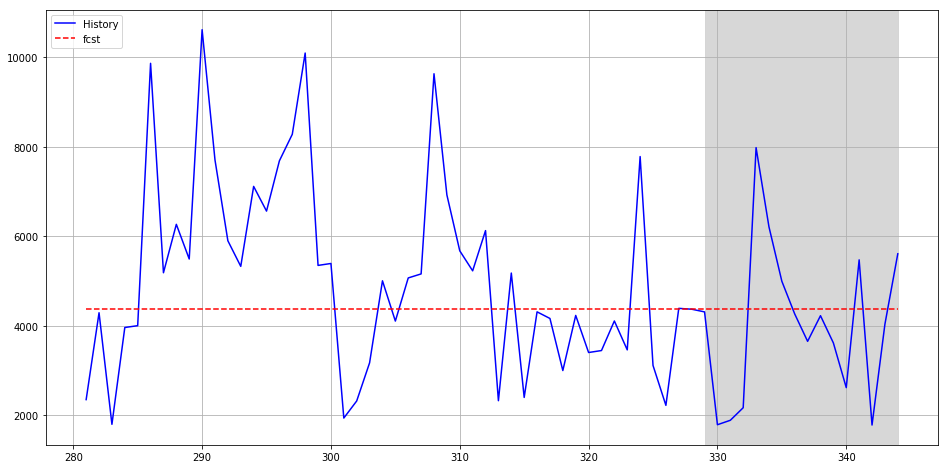

In [31]:
naive_fcst = naive(train_df)
fcst_plot(fcst_df.iloc[-64:,2],naive_fcst.iloc[-64:].to_frame())

### Simple Average:
### $\hat{y}_{x+1} = \frac{1}{x} \sum_{i=1}^{x} y_i$

In [32]:
def avg_fcst(hist,periods=16):
    fcst_df = hist.copy()
    fcst = hist.iloc[:-16].mean()
    for i in range(len(hist)+periods):
        fcst_df.loc[i] = fcst
        
    return fcst_df

MAPE: 0.47523063088423606


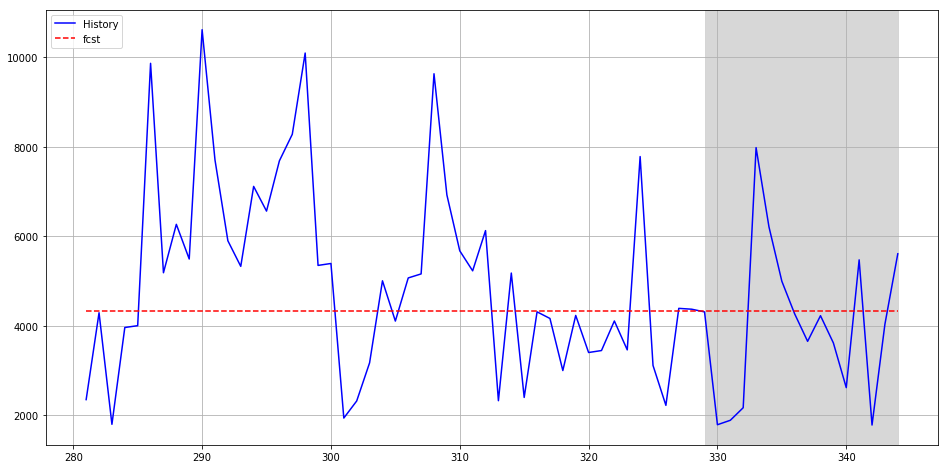

In [33]:
average = avg_fcst(train_df)
fcst_plot(fcst_df.iloc[-64:,2],average.iloc[-64:].to_frame())

### Moving Average:
### $\hat{y}_{x+1} = \frac{1}{n} \sum_{i=1}^{n} y_i$

In [34]:
def mvg_avg(hist,periods=16,n=3):
    fcst_df = hist.copy()
    for i in range(len(hist)+periods):
        if i < n:
            continue
        elif i > len(hist):
            fcst_df.loc[i] = fcst_df.iloc[i-n:i].mean()
        else:    
            fcst_df.loc[i] = hist.iloc[i-n:i].mean()
    return fcst_df
        

MAPE: 0.41024653903583874


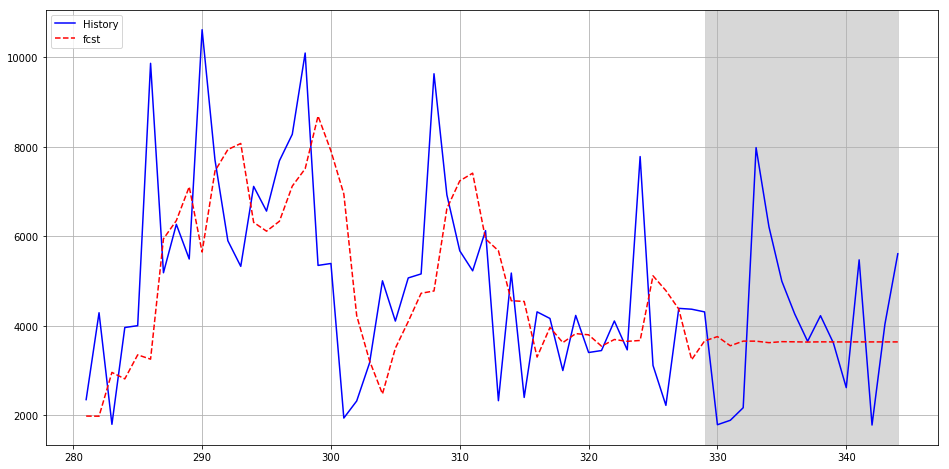

In [35]:
moving_avg = mvg_avg(train_df)
fcst_plot(fcst_df.iloc[-64:,2],moving_avg.iloc[-64:].to_frame())

### Weighted Moving Average:
### $\hat{y}_{x+1} = \sum_{i=1}^{w} y_i*w_i$

In [37]:
def wgt_avg(hist,periods=16,weights=[.5,.3,.2]):
    fcst_df = hist.copy()
    for i in range(len(hist)+periods):
        if i < len(weights):
            continue
        elif i > len(hist):
            fcst_df.loc[i] = sum(fcst_df.iloc[i-len(weights):i] * np.array(weights))
            
        else:    
            fcst_df.loc[i] = sum(hist.iloc[i-len(weights):i] * np.array(weights))
            
    return fcst_df

MAPE: 0.4232783957403788


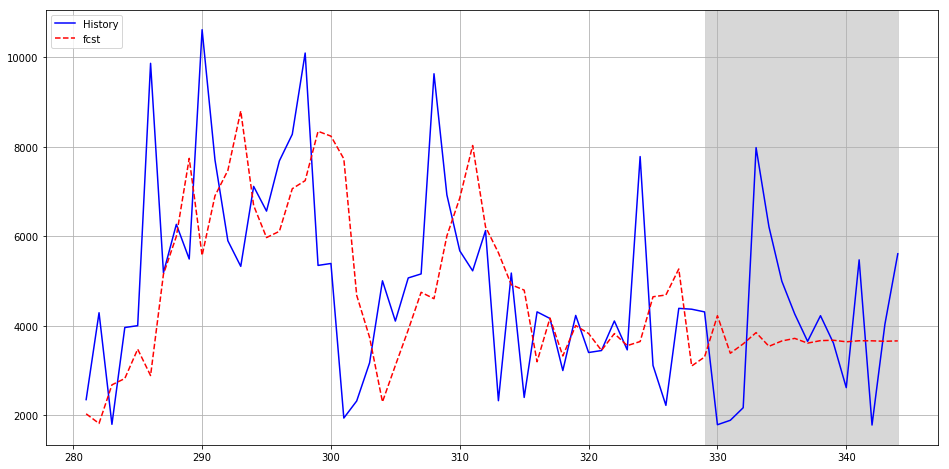

In [38]:
weighted = wgt_avg(train_df,weights=[.5,.3,.2])
fcst_plot(fcst_df.iloc[-64:,2],weighted.iloc[-64:].to_frame())

### Single Exponential Smoothing:
### $\hat{y}_{x} = \alpha * y_{x} + (1 - \alpha) * \hat{y}_{x-1}$

In [39]:
def single_ex_smooth(hist, alpha=0.8, periods=16):
    fsct_df = hist.copy()
    
    for i in range(len(hist) + periods):
        if i == 0: next
        elif i < len(hist):
            fcst_df.loc[i] = (alpha * hist.loc[i]) + (1 - alpha) * fcst_df.loc[i-1]
        else:
            fcst_df.loc[i] = fcst_df.loc[i-1]
    return fcst_df

In [40]:
weighted = single_ex_smooth(train_df,weights=[.5,.3,.2])
fcst_plot(fcst_df.iloc[-64:,2],weighted.iloc[-64:].to_frame())

TypeError: single_ex_smooth() got an unexpected keyword argument 'weights'

### Double Exponential Smoothing:
### Level: ${l}_{x} = \alpha y_{x} + (1 - \alpha)({l}_{x-1} + {b}_{x-1})$
### Trend: ${b}_{x} = \beta(l_{x} - l_{x-1}) + (1 - \beta){b}_{x-1}$
### Forecast:  $\hat{y}_{x} = {l}_{x} + {b}_{x}$

In [41]:
def double_ex_smoothing(hist, alpha = 0.8, beta = .1, periods=16):
    fcst_df = hist.copy()
    level_df = hist.copy()
    trend_df = hist.copy()
    
    trend_df.loc[0] = hist.loc[1] - hist.loc[0]
    
    for i in range(len(hist) + periods):
        if i == 0: next
        elif i < len(hist):
            level_df.loc[i] = (alpha * hist.loc[i]) + (1-alpha)*(level_df.loc[i-1] + trend_df.loc[i-1])
            trend_df.loc[i] = beta*(level_df.loc[i] - level_df.loc[i-1]) + (1- beta)*trend_df.loc[i-1]
            final_trend = trend_df.loc[i]
            final_level = level_df.loc[i]
        else:
            trend_df.loc[i] = trend_df.loc[i-1] + final_trend
            fcst_df.loc[i] = final_level + trend_df[i]
    
    fcst_df[fcst_df < 0] = 0
    return fcst_df
        
    

MAPE: 0.4197383561162035


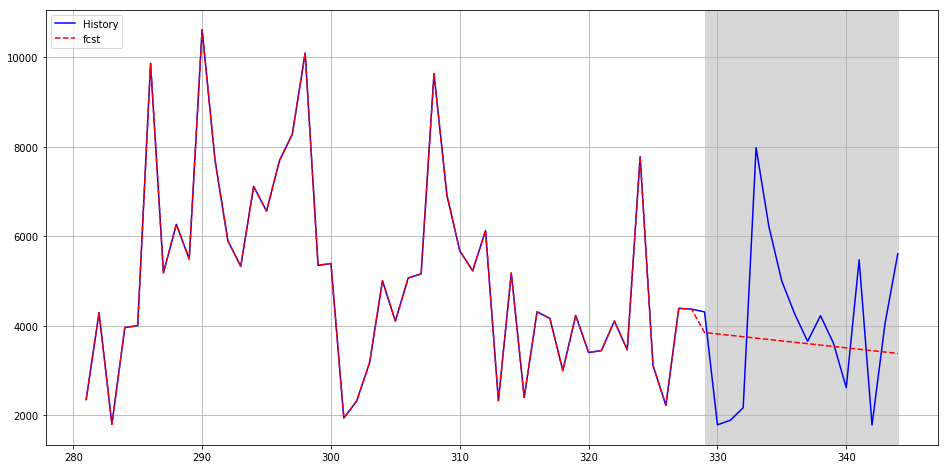

In [44]:
double_ex = double_ex_smoothing(train_df, alpha = 0.5, beta = .5, periods=16)
fcst_plot(fcst_df.iloc[-64:,2],double_ex.iloc[-64:].to_frame())

### Holt-Winters Triple Exponential Smoothing:
### Level: ${l}_{x} = \alpha(y_{x} - s_{x-L}) + (1 - \alpha)({l}_{x-1} + {b}_{x-1})$
### Trend: ${b}_{x} = \beta(l_{x} - l_{x-1}) + (1 - \beta){b}_{x-1})$
### Seasonal: ${s}_{x} = \gamma({y}_{x} - l_{x}) + (1 - \gamma){s}_{x-L}$
### Forecast:  $\hat{y}_{x+m} = {l}_{x} + {mb}_{x} + {s}_{x-L+1+(m-1)modL}$

In [49]:
!pip install statsmodels

You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [50]:
from statsmodels.tsa.api import ExponentialSmoothing

fit_holt_winters = ExponentialSmoothing(np.asarray(train_df['TotalDuration']) ,seasonal_periods=16 ,trend='add', damped=False, seasonal='add',).fit()
fcst_holt_winters = fit_holt_winters.predict(start=0,end=344)
holt_winters = pd.DataFrame(fcst_holt_winters,columns=['TotalDuration'])
fcst_plot(fcst_df.iloc[-64:,2],holt_winters.iloc[-64:,:])

ImportError: cannot import name 'ExponentialSmoothing'

In [ ]:
fit_holt_winters = ExponentialSmoothing(np.asarray(train_df['TotalDuration']) ,seasonal_periods=16 ,trend='add', damped=True, seasonal='add',).fit()
fcst_holt_winters = fit_holt_winters.predict(start=0,end=344)
holt_winters = pd.DataFrame(fcst_holt_winters,columns=['TotalDuration'])
fcst_plot(fcst_df.iloc[-64:,2],holt_winters.iloc[-64:,:])

### Auto Regressive Integrated Moving Average (ARIMA - Box-Jenkins)
### $\hat{y}_{t} = \mu + {\phi}_{1}{y}_{t-1}+...+{\phi}_{p}{y}_{t-p} - {\theta}_{1}{e}_{t-1} -...-{\theta}_{q}{e}_{t-q}$ 

In [ ]:
from pmdarima import auto_arima

stepwise_model = auto_arima(train_df['TotalDuration'], start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                            start_P=1, seasonal=True, error_action='ignore',
                            suppress_warnings=True, stepwise=True)

in_sample = stepwise_model.predict_in_sample()
forecast = stepwise_model.fit_predict(train_df['TotalDuration'],n_periods=16)
ARIMA_fcst = np.append(in_sample,forecast)
ARIMA = pd.DataFrame(ARIMA_fcst,columns=['TotalDuration'])

In [ ]:
fcst_plot(fcst_df.iloc[-64:,2],ARIMA.iloc[-64:,:])

### LSTM Recurrent Neural Network
### $i_{t} = \sigma(x_{t}U^i + h_{t-1}W^i)$
### $f_{t} = \sigma(x_{t}U^f + h_{t-1}W^f)$
### $o_{t} = \sigma(x_{t}U^o + h_{t-1}W^o)$
### $\hat{C}_{t} = tanh(x_{t}U^g + h_{t-1}W^g)$
### $C_{t} = \sigma(f_{t} * C_{t-1} + i_t * \hat{C}_{t})$
### $h_{t} = tanh(C_{t}) * o_i$

In [ ]:
import math
import numpy
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [ ]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

# fix random seed for reproducibility
numpy.random.seed(7)

# load the dataset
dataframe = fcst_df['TotalDuration'].to_frame()
dataset = dataframe.values
dataset = dataset.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

train_size = len(dataset) - 20
test_size = len(dataset) - train_size

train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [ ]:
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
# create and fit the LSTM network
batch_size = 1
model = Sequential()
model.add(LSTM(16, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
model.add(LSTM(16, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
for i in range(50):
    print("Epoch:",i)
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
    model.reset_states()

In [ ]:
# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [ ]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

In [ ]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(scaler.inverse_transform(dataset[-64:-1]),'b-',label='History')
plt.plot(trainPredictPlot[-64:],'--',label='lstm_fit')
plt.plot(testPredictPlot[-64:],'r--',label='lstm_predict')
plt.axvspan(47,62,alpha=0.9,color='lightgrey')
plt.legend(loc='best')
plt.grid(True)

In [ ]:
lstm_mape = fcst_error(scaler.inverse_transform(dataset[-17:-1]), testPredictPlot[-17:-1])
lstm_mape